# Problem set 3: Sentiment

## Description

The goal of this problem set is to compare the sentiments associated with male and female characters in a small corpus of 41 novels. 

This task has a bit in common with Erin Davis's work on the adjectives and body parts associated with male and female characters, though our task is significantly less complex (because we are not doing dependency parsing in order to associate specific words with individual character references).

Here's the approach you should implement:

1. For each text in the corpus ...
1. Break the text into sentences and tokenize each sentence.
1. Assign a subject gender to each sentence by counting occurrences of gendered words ("he", "she", etc.). Refine these lists as you see fit. 
  1. Optional: devise ways to treat gender as a non-binary variable.
1. Assign sentiment scores to each sentence using the 10 sentiment types included in the NRC EmoLex lexicon ("anticipation", "disgust", "trust", etc.).
1. Calculate the mean sentiment score(s) for the sentences in the text that you identified as male-centric and female-centric. 
  1. Optional: If you chose to work with non-binary gender assignments, devise an appropriate way to group gender-similar sentences using your assignments. 
1. Compare your grouped sentiment scores among the novels in the corpus. 
1. Write roughly one paragraph of analysis and conclusions.

Let's get to it. 

The next block of code contains some variables and import statements. **Make sure your variables point to the correct files on your system.** Get these files from the course GitHub site.

In [6]:
from   collections import defaultdict
from   glob import glob
from   nltk import word_tokenize, sent_tokenize
import numpy as np
import os
import string

# Files and locations
novel_files = glob(os.path.join('..', '..', 'data', 'texts', '*.txt'))
emolex_file = os.path.join('..', '..', 'data', 'lexicons', 'emolex.txt')

# Female and male wordlist from Neal Caron via Bengfort et al.
# See bit.ly/2GJBGfV
male_words = set([
    'guy','spokesman','chairman',"men's",'men','him',"he's",'his',
    'boy','boyfriend','boyfriends','boys','brother','brothers','dad',
    'dads','dude','father','fathers','fiance','gentleman','gentlemen',
    'god','grandfather','grandpa','grandson','groom','he','himself',
    'husband','husbands','king','male','man','mr','nephew','nephews',
    'priest','prince','son','sons','uncle','uncles','waiter','widower',
    'widowers'
])

female_words = set([
    'heroine','spokeswoman','chairwoman',"women's",'actress','women',
    "she's",'her','aunt','aunts','bride','daughter','daughters','female',
    'fiancee','girl','girlfriend','girlfriends','girls','goddess',
    'granddaughter','grandma','grandmother','herself','ladies','lady',
    'lady','mom','moms','mother','mothers','mrs','ms','niece','nieces',
    'priestess','princess','queens','she','sister','sisters','waitress',
    'widow','widows','wife','wives','woman'
])

dev_text = '''\
    He was the father of modern gardening. 
    She is the mother of computer science. 
    They are both excellent at their jobs.
    Jane is generally happy with her work.
    Jonathan had a bad day, but he's fine.
    He and she are the parents of a girl.'''

## Tokenize and preprocess text (10 points)

**Write a function, `tokenize_text`, that takes as input a text string and returns a list sentences, each of which contains a list of tokens.** We'll use this function to tokenize each novel.

Your tokenized text should be all lowercase. You may remove punctuation and stopwords, but be careful not to remove any of the gender-indicative pronouns that are included in the `male_words` and `female_words` lists above. 

**Run your `tokenize_text` function on the `dev_text` string and print the result.**

In [7]:
def tokenize_text(text, stopwords=None):
    '''
    Takes a string.
    Returns a list of tokenized sentences.
    '''
    
    tokenized = []
    for sent in sent_tokenize(text):
        tokens = word_tokenize(sent)
#         if stopwords != None: 
#             tokens = [token for token in tokens if token not in stopwords]
        tokenized.append(tokens)
    return tokenized
            

# Display your results
display(tokenize_text(dev_text))

[['He', 'was', 'the', 'father', 'of', 'modern', 'gardening', '.'],
 ['She', 'is', 'the', 'mother', 'of', 'computer', 'science', '.'],
 ['They', 'are', 'both', 'excellent', 'at', 'their', 'jobs', '.'],
 ['Jane', 'is', 'generally', 'happy', 'with', 'her', 'work', '.'],
 ['Jonathan', 'had', 'a', 'bad', 'day', ',', 'but', 'he', "'s", 'fine', '.'],
 ['He', 'and', 'she', 'are', 'the', 'parents', 'of', 'a', 'girl', '.']]

## Assign gender scores (10 points)

**Write a function, `gender_score`, that takes as input a list of word-level tokens and returns a gender score. Run this function over the tokenized sentences in `dev_text` and print the resulting scores.**

The list of input tokens represents a single, tokenized sentence.

The gender score may be either binary for female/male (according to the prepoderance of male or female terms in the sentence, `1 = female`, `0 = male`) or a floating-point number between 0 (male) and 1 (female) that represents the proportion of female and male words from the lists above. In either case, think about how you want to represent sentences that have no gender terms.

In [8]:
from collections import Counter
def gender_score(token_list, male_words, female_words, binary=True):
    '''
    Takes a list of tokens.
    Returns a gender score between 0 and 1, or None.
    '''
    if binary is False:
        gender_c = 0
        all_c = 0
        for i in token_list:
            i = i.lower()
            if i in male_words or i in female_words:
                gender_c += 1
            all_c += 1
        if gender_c == 0:
            return None 
        else: 
            return(gender_c/all_c)
        
    else: 
        gender_c = Counter()
        for i in token_list: 
            i = i.lower()
            if i in male_words:
                gender_c['male'] += 1
            elif i in female_words:
                gender_c['female'] +=1
        if gender_c['male'] > gender_c['female']:
            return 0
        elif gender_c['male'] < gender_c['female']:
            return 1
        else: 
            return None 

In [9]:
# Run your gender-scoring function on the tokenized dev_text
for sent in enumerate(tokenize_text(dev_text),1):
    print("Sent:", sent[0], "\tGender:", gender_score(sent[1],male_words, female_words))

Sent: 1 	Gender: 0
Sent: 2 	Gender: 1
Sent: 3 	Gender: None
Sent: 4 	Gender: 1
Sent: 5 	Gender: 0
Sent: 6 	Gender: 1


## Calculate sentence-level sentiment scores (20 points)

**Write a function, `sentiment_score`, that takes as input a list of word-level tokens and an EmoLex lexicon and returns a dictionary of length-normalized EmoLex sentiment scores for every available emotion type. Run this function over the tokenized sentences in `dev_text` and print the resulting sentence-level scores.**

The list of tokens used as input data represents a single, tokenized sentence.
By "length-normalized," I mean that each sentence-level score should be divided by the number of tokens in the sentence.

Your output dictionary should look like this (sample output on the fourth `dev_text` sentence):

```
{
  'anger': 0.0, 
  'anticipation': 0.125, 
  'disgust': 0.0, 
  'fear': 0.0, 
  'joy': 0.125, 
  'negative': 0.0, 
  'positive': 0.125, 
  'sadness': 0.0, 
  'surprise': 0.0, 
  'trust': 0.125
}
```

In [10]:
# A freebie helper function to read and parse the emolex file
def read_emolex(filepath=None):
    '''
    Takes a file path to the emolex lexicon file.
    Returns a dictionary of emolex sentiment values.
    '''
    if filepath==None: # Try to find the emolex file
        filepath = os.path.join('..','..','data','lexicons','emolex.txt')
        if os.path.isfile(filepath):
            pass
        elif os.path.isfile('emolex.txt'):
            filepath = 'emolex.txt'
        else:
            raise FileNotFoundError('No EmoLex file found')
    emolex = defaultdict(dict) # Like Counter(), defaultdict eases dictionary creation
    with open(filepath, 'r') as f:
    # emolex file format is: word emotion value
        for line in f:
            word, emotion, value = line.strip().split()
            emolex[word][emotion] = int(value)
    return emolex

# Get EmoLex data. Make sure you set the right file path above.
emolex = read_emolex(emolex_file)

In [11]:
# Sentiment scoring function
def sentiment_score(token_list, lexicon=None):
    '''
    Takes a tokenized sentence.
    Returns a dictionary of length-normalized EmoLex sentiment scores.
    '''
    sent_score = {
  'anger': 0.0, 
  'anticipation': 0.0, 
  'disgust': 0.0, 
  'fear': 0.0, 
  'joy': 0.0, 
  'negative': 0.0, 
  'positive': 0.0, 
  'sadness': 0.0, 
  'surprise': 0.0, 
  'trust': 0.0
    }
    count = 0
    for i in token_list:
        if i in emolex:
            for x in sent_score:
                sent_score[x] = sent_score[x] + emolex[i][x]
        count += 1
    for i in sent_score:
        sent_score[i] = sent_score[i]/count
    return(sent_score)

# Run scoring function on tokenized dev text and print results
for sent in enumerate(tokenize_text(dev_text),1):
    print("Sent:", sent[0], "\tSentiment:", sentiment_score(sent[1]))

Sent: 1 	Sentiment: {'anger': 0.0, 'anticipation': 0.0, 'disgust': 0.0, 'fear': 0.0, 'joy': 0.0, 'negative': 0.0, 'positive': 0.0, 'sadness': 0.0, 'surprise': 0.0, 'trust': 0.125}
Sent: 2 	Sentiment: {'anger': 0.0, 'anticipation': 0.125, 'disgust': 0.0, 'fear': 0.0, 'joy': 0.125, 'negative': 0.125, 'positive': 0.125, 'sadness': 0.125, 'surprise': 0.0, 'trust': 0.125}
Sent: 3 	Sentiment: {'anger': 0.0, 'anticipation': 0.0, 'disgust': 0.0, 'fear': 0.0, 'joy': 0.125, 'negative': 0.0, 'positive': 0.125, 'sadness': 0.0, 'surprise': 0.0, 'trust': 0.125}
Sent: 4 	Sentiment: {'anger': 0.0, 'anticipation': 0.125, 'disgust': 0.0, 'fear': 0.0, 'joy': 0.125, 'negative': 0.0, 'positive': 0.125, 'sadness': 0.0, 'surprise': 0.0, 'trust': 0.125}
Sent: 5 	Sentiment: {'anger': 0.09090909090909091, 'anticipation': 0.0, 'disgust': 0.09090909090909091, 'fear': 0.09090909090909091, 'joy': 0.0, 'negative': 0.09090909090909091, 'positive': 0.0, 'sadness': 0.09090909090909091, 'surprise': 0.0, 'trust': 0.0}
Se

## Compare emotions in female- and male-tagged sentences (20 points)

**Write a function, `gendered_sentiment`, that uses `gender_score` and `sentiment_score` to  calulate the mean sentiment scores for each EmoLex emotion type in female- and male-tagged sentences in a tokenized input text. Then print the output of this function when run on tokenized `dev_text`.**

We've done this somewhat ineffeciently, since each of those functions iterates over all tokens (so we make two passes over the text). But this inefficiency made it easier to break up the task into its constituent parts.

Your function should take as input a tokenized text and should return a dictionary with keys for each emotion type, subkeys `male` and `female`, and values representing the mean score for that emotion in sentences corresponding to the indicated gender. For example (invented, not real data):

```
{
  'anger':  {
    'male' : 0.02,
    'female' : 0.03
  },
  ...
}
```

If you chose to operationalize gender as a nonbinary value, you'll need to decide how to treat values other than 0 and 1. You could split at 0.5 (how do you want to treat gender scores equal to 0.5?) or discard mid-level scores (between 0.3 and 0.7, say), or some other approach. And, no matter how you calculated your gender score, you'll need to handle genderless sentences appropriately (by ignoring them).

In [41]:
# Sentiment comparison by gender
def gendered_sentiment(tokenized_text, lexicon=None, binary=True, female_level=0.7, male_level=None):
    all_score = {
#     'anger': {'male': 0.0, 'female':0.0}, 
#     'anticipation': {'male': 0.0, 'female':0.0}, 
#     'disgust': {'male': 0.0, 'female':0.0}, 
#     'fear': {'male': 0.0, 'female':0.0}, 
#     'joy': {'male': 0.0, 'female':0.0}, 
#     'negative': {'male': 0.0, 'female':0.0}, 
#     'positive': {'male': 0.0, 'female':0.0}, 
#     'sadness': {'male': 0.0, 'female':0.0}, 
#     'surprise': {'male': 0.0, 'female':0.0}, 
#     'trust': {'male': 0.0, 'female':0.0}
        'male':{
      'anger': 0.0, 
      'anticipation': 0.0, 
      'disgust': 0.0, 
      'fear': 0.0, 
      'joy': 0.0, 
      'negative': 0.0, 
      'positive': 0.0, 
      'sadness': 0.0, 
      'surprise': 0.0, 
      'trust': 0.0
        },
        'female':{
      'anger': 0.0, 
      'anticipation': 0.0, 
      'disgust': 0.0, 
      'fear': 0.0, 
      'joy': 0.0, 
      'negative': 0.0, 
      'positive': 0.0, 
      'sadness': 0.0, 
      'surprise': 0.0, 
      'trust': 0.0
        }
    }
    
    sent_score = {
      'anger': 0.0, 
      'anticipation': 0.0, 
      'disgust': 0.0, 
      'fear': 0.0, 
      'joy': 0.0, 
      'negative': 0.0, 
      'positive': 0.0, 
      'sadness': 0.0, 
      'surprise': 0.0, 
      'trust': 0.0
        }

    for i in tokenized_text: 
        gender_c = Counter()
        emo_c = Counter()
        all_c = 0
        for x in i:
            x = x.lower()
            if x in male_words: 
                gender_c['male'] += 1
            if x in female_words:
                gender_c['female'] +=1
            if x in emolex:
                for y in sent_score: 
                    emo_c[y] += emolex[x][y]
        if gender_c['male'] > gender_c['female']:
            for a in sent_score:
                all_score['male'][a] += emo_c[a]
                all_score['male'][a] = (all_score['male'][a])/gender_c['male']
        elif gender_c['male'] < gender_c['female']:
             for a in sent_score:
                all_score['female'][a] += emo_c[a]
                all_score['female'][a] = (all_score['female'][a])/gender_c['female']
        else:
            None
    return(all_score)
# Run function and display results
scores = gendered_sentiment(tokenize_text(dev_text), lexicon=emolex)
display(scores)

{'male': {'anger': 1.0,
  'anticipation': 0.0,
  'disgust': 1.0,
  'fear': 1.0,
  'joy': 0.0,
  'negative': 1.0,
  'positive': 0.0,
  'sadness': 1.0,
  'surprise': 0.0,
  'trust': 0.5},
 'female': {'anger': 0.0,
  'anticipation': 0.75,
  'disgust': 0.0,
  'fear': 0.0,
  'joy': 0.75,
  'negative': 0.25,
  'positive': 0.75,
  'sadness': 0.25,
  'surprise': 0.0,
  'trust': 0.75}}

## Visualize your output (5 points)

This one's a freebie, so long as the output of your `gendered_sentiment` function meets the problem spec. 

**Use the `visualize_emotion_scores` function below to produce a plot of your comparative gender scores in `dev_text` for all 10 emotion categories.**

In [42]:
%matplotlib inline
def visualize_emotion_scores(scores):
    import pandas as pd
    import seaborn as sns
    df = pd.DataFrame.from_dict(scores)
    values = df.columns
    df = df.reset_index().melt(id_vars='index', value_vars=values, var_name='emotion').rename(columns={'index':'gender'})
    sns.set_context('poster')
    g = sns.catplot(x='gender', y='value', col='emotion', data=df, kind='bar', col_wrap=4)
    return g

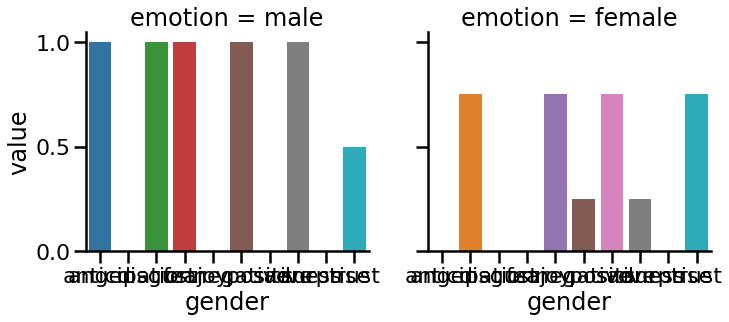

In [43]:
g = visualize_emotion_scores(scores)

## Calculate scores in a novel (5 points)

**Use the code you've written to calculate and plot the gendered emotion scores in *Madame Bovary*.**

Your output should include both the mean scores printed to standard output (here in the notebook) and a visualization created using the `visualize_emotion_scores` function.

Incidentally, working with large texts can be slow. But scoring a novel as we've done here shouldn't take more than a few seconds. If you're waiting minutes for your scoring to finish, something is wrong.

In [ ]:
bovary_path = os.path.join('..','..','data','texts','F-Flaubert-Madame_Bovary-1857-M.txt')
with open(bovary_path, 'r') as f:
    bovary_text = f.read()
bovary = tokenize_text(bovary_text)

Your code here

## Grand finale: Sentiment and gender in a small corpus (20 points)

**Do the same thing you just did for one novel, but for all 41 novels in the `data/texts` directory (from GitHub). Calculate the mean sentiment score across the corpus for each emotion and each gender, as well as the standard deviation for each of those means. Display your results in a legible form.**

In [ ]:
%%time
# Score all 41 novels in the corpus
# Takes about a minute on my aging laptop

corpus_scores = {} # Dictionary to hold results
for novel in novel_files: # Iterate over novels
    with open(novel, 'r') as f:
        novel_text = f.read() # Read a novel as a string
    novel_label = os.path.split(novel)[1].rstrip('.txt') # Get convenience label for novel
    Your code here

In [ ]:
# Aggregate scores for all novels by emotion type and gender
Your code here

In [ ]:
# Calculate corpus-wide means and standard deviations
Your code here

## Discuss your results (10 points)

Write a short paragraph in which you summarize your findings and suggest ways in which the experiment might be improved.

Your discussion in this MarkDown cell ...

## Optional bonus (10 points)

Extend your analysis to different author genders, nationalities, or time periods. 

The files in the corpus are informatively named:

```
Nation-Author-Title-Year-Gender.txt
```

Use the convenience function below to parse the corpus file paths into a dictionary of metadata, then segment the corpus-wide emotion scores into one or more dimensions by author gender, nation of origin, or era of publication. Do you notice any interesting trends in this segmented data?

**NB.** We're obviously not imposing much statistical rigor here, and we're working with a very small corpus. Treat your results as a toy example!

In [ ]:
# Convenience function to parse file paths into metadata
def parse_filename(path):
    '''
    Takes a formatted file path string.
    Returns a dictionary of metadata about that file.
    '''
    name = os.path.split(path)[1]
    metadata = {} # Dict to hold filename:[categories] mappings
    parsed = name.rstrip('.txt').split('-') # strip extension and split on hyphens
    metadata['nation'] = parsed[0]
    metadata['author'] = parsed[1]
    metadata['title']  = parsed[2]
    metadata['year']   = parsed[3]
    metadata['gender'] = parsed[4]
    return metadata